# 0.0 IMPORTS

In [1]:
import random
import warnings
from pandas_profiling import ProfileReport
import pandas      as pd
import numpy       as np
import seaborn     as sns

import matplotlib.pyplot as plt
from category_encoders       import TargetEncoder
from sklearn.metrics         import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn                import combine as c
from imblearn                import under_sampling as us
from imblearn                import over_sampling as oversamp
from scipy                   import stats as ss
from sklearn                 import model_selection as ms
from sklearn                 import preprocessing as pp
from sklearn                 import metrics       as m
from keras                   import models as ml
from keras                   import layers as l
#from pandas_profiling        import ProfileReport
from IPython.core.display    import HTML

warnings.filterwarnings( 'ignore' )

C:\Users\PC\anaconda3\envs\pa006_airbnb\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

#def jupyter_settings():
#    %matplotlib inline
#    %pylab inline
#    
#    plt.style.use( 'bmh' )
#    plt.rcParams['figure.figsize'] = [25, 12]
#    plt.rcParams['font.size'] = 24
#    
#    display( HTML( '<style>.container { width:100% !important; }</style>') )
#    pd.options.display.max_columns = None
#    pd.options.display.max_rows = None
#    pd.set_option( 'display.expand_frame_repr', False )
#    
#    sns.set()

## 0.2 Loading Data

In [3]:
df_raw = pd.read_csv('C:/Users/PC/SejaUmDataScientist/DS_Classificacao/airbnb_project/Data/train_users.csv', low_memory=True) 

df_sessions = pd.read_csv('C:/Users/PC/SejaUmDataScientist/DS_Classificacao/airbnb_project/Data/sessions.csv', low_memory=True)


# 1.0 Passo 01 - DESCRIÇÃO DOS DADOS

In [4]:
df1 = df_raw.copy()
df1_sessions = df_sessions.copy()

## 1.1 Data Dimensions

In [5]:
print(f'Número de linhas é igual a: {df1.shape[0]}')
print(f'Número de colunas é igual a: {df1.shape[1]}')

Número de linhas é igual a: 213451
Número de colunas é igual a: 16


In [6]:
#Sessions
print(f'Número de linhas é igual a: {df1_sessions.shape[0]}')
print(f'Número de colunas é igual a: {df1_sessions.shape[1]}')

Número de linhas é igual a: 10567737
Número de colunas é igual a: 6


## 1.2 Data Types

In [7]:
#Data types df1
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [8]:
#Data types df1_sessions
df1_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3 Check NA

In [9]:
df1.isna().sum() /len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [10]:
df1_sessions.isna().sum()/len(df1_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [11]:
df1['first_affiliate_tracked'].drop_duplicates()
#aux = df1[df1[ 'age'].isna()]
#aux['country_destination'].value_counts(normalize=True)

0            untracked
5                  omg
12                 NaN
13              linked
79       tracked-other
257            product
6270         marketing
11184        local ops
Name: first_affiliate_tracked, dtype: object

In [12]:
#Remover NAs
# =====================USERS======================================

#date_first_booking
date_first_booking_max =  pd.to_datetime( df1['date_first_booking']).max().strftime('%Y%m%d')

df1['date_first_booking'] = df1['date_first_booking'].fillna( date_first_booking_max)


#age: Preencher como valor médio
df1 = df1[( df1['age'] > 15 ) & ( df1['age'] < 120 )]
avg_age = df1['age'].mean()
df1['age'] = df1['age'].fillna( avg_age).astype(int)

#first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]


#============================================SESSIONS=========================================
#user_id        3%
df1_sessions = df1_sessions[~df1_sessions['user_id'].isna()]

#action         0.7%
df1_sessions = df1_sessions[~df1_sessions['action'].isna()]

#action_type    11%
df1_sessions = df1_sessions[~df1_sessions['action_type'].isna()]

#action_detail  11%
df1_sessions = df1_sessions[~df1_sessions['action_detail'].isna()]

#secs_elapsed   1.2%
df1_sessions = df1_sessions[~df1_sessions['secs_elapsed'].isna()]

In [13]:
df1.isna().sum() / len( df1 )

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

In [14]:
df_sessions.isna().sum() / len( df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## 1.4 Change Data Types

In [15]:
df1.dtypes

id                         object
date_account_created       object
timestamp_first_active      int64
date_first_booking         object
gender                     object
age                         int32
signup_method              object
signup_flow                 int64
language                   object
affiliate_channel          object
affiliate_provider         object
first_affiliate_tracked    object
signup_app                 object
first_device_type          object
first_browser              object
country_destination        object
dtype: object

In [16]:
#date_account_created   
df1['date_account_created']=pd.to_datetime( df1['date_account_created'])
#timestamp_first_active  
df1['timestamp_first_active']=pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

#date_first_booking
df1['date_first_booking']=pd.to_datetime( df1['date_first_booking'])
#age                      
df1['age']= df1['age'].astype('int64')


## 1.5 Check Balanced Data

In [17]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## 1.6 Descriptive Analyses

In [18]:
#==================Users===================================
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes = df1.select_dtypes( include= ['datetime64[ns]'])


#====================Sessions==========================================
num_attributes_sessions  = df1_sessions.select_dtypes( include=['int64', 'float64'])
cat_attributes_sessions  = df1_sessions.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_sessions = df1_sessions.select_dtypes( include= ['datetime64[ns]'])

### 1.6.1 Numerical -Users

In [19]:
#central tendency - Mean and Median
ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply(np.median)).T

#Dispersions -  std, min, max. range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply(min)).T
d3 = pd.DataFrame( num_attributes.apply(max)).T
d4 = pd.DataFrame( num_attributes.apply( lambda x : x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x : x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x : x.kurtosis() )).T

#Concatenar
ct = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


### 1.6.1 Numerical -Sessions

In [20]:
#central tendency - Mean and Median
ct1 = pd.DataFrame( num_attributes_sessions.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes_sessions.apply(np.median)).T

#Dispersions -  std, min, max. range, skew, kurtosis
d1 = pd.DataFrame( num_attributes_sessions.apply(np.std)).T
d2 = pd.DataFrame( num_attributes_sessions.apply(min)).T
d3 = pd.DataFrame( num_attributes_sessions.apply(max)).T
d4 = pd.DataFrame( num_attributes_sessions.apply( lambda x : x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes_sessions.apply( lambda x : x.skew() )).T
d6 = pd.DataFrame( num_attributes_sessions.apply( lambda x : x.kurtosis() )).T

#Concatenar
ct = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.6.2 Numerical - Users

In [21]:
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 1.6.3 Categorical -Sessions

In [22]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [23]:
#lista de atributos para cramer v
cat_attributes_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}

for i in range( len(cat_attributes_list) ):
    corr_list = []
    
    for j in range (len(cat_attributes_list ) ):
        ref  = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        #Correlação
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat] )
        
        #append a list
        corr_list.append( corr )
    # append correlation para cada ref atrtibuts
    corr_dict[ref] = corr_list

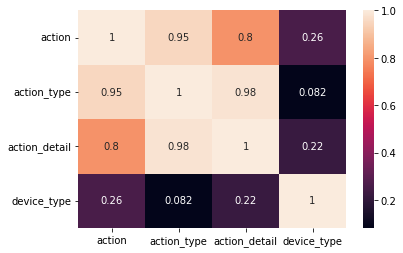

In [24]:
d = pd.DataFrame( corr_dict)
d = d.set_index(d.columns)
sns.heatmap( d, annot=True);

# 2.0 PASSO 02 - Feature Engeneering


In [25]:
df2 =df1.copy()

df2.shape


(122636, 16)

In [26]:
df2.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 2.1 Create new Features

In [27]:
# days from first activate up to first booking
df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime("%Y-%m-%d") )
df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] -df2['first_active']).apply( lambda x: x.days)

#days from first activate up to account create
df2['days_from_first_active_until_account_created'] = (df2['date_account_created'] -df2['first_active']).apply( lambda x: x.days)

#days from account create up to first booking
df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] -df2['date_account_created']).apply( lambda x: x.days)
    

#===================================First activate======================================
#Year first active
df2['year_first_active'] = df2['first_active'].dt.year

#Month first active
df2['month_first_active'] = df2['first_active'].dt.month


#Day first active
df2['day_first_active'] = df2['first_active'].dt.day


#Day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek


#Week of year first active
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear


#===================================Booking======================================
#Year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

#Month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

#Day first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

#Day of Week of first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

#Week of first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear


#===================================First account created======================================
#Year first active
df2['year_account_created'] = df2['date_account_created'].dt.year

#Month first active
df2['month_account_created'] = df2['date_account_created'].dt.month


#Day first active
df2['day_account_created'] = df2['date_account_created'].dt.day


#Day of week first active
df2['day_of _week_first_account_created'] = df2['date_account_created'].dt.dayofweek


#Week of year first active
df2['week_of _year_first_account_created'] = df2['date_account_created'].dt.weekofyear




In [28]:
df2.shape

(122636, 35)

# 3.0 PASSO 03 - Data Filtering


In [29]:
df3 = df2.copy()

## 3.1 Filtering Rows

In [30]:
#Age:entre 15 e 120 pois há poucas pessoas como mais de 120 anos
df3 =  df3[( df2['age']> 15) & (df3['age'] < 120 )]

# secs_elapsed - Não há possibilidade de ter 0 elapsed
#df1_sessions = df1_sessions[ df1_sessions['secs_elapsed']> 0]

## 3.2 Columns Selection

In [31]:
 cols = ['date_account_created', 'date_account_created', 'date_first_booking', 'timestamp_first_active', 
        'first_active'] # original datetime

# 4.0 - BALANCED DATASET

In [32]:
df4 = df3.drop( cols, axis=1 )
df4.shape

(122636, 31)

In [33]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
col_num = df4.select_dtypes( include=['int64', 'float64'] ).columns.tolist()

# Categorical
col_cat = df4.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] ).drop( ['id', 'country_destination'], axis=1 ).columns.tolist()

# encoding
df4_dummy = pd.DataFrame( ohe.fit_transform( df4[ col_cat] ).toarray(), index=df4.index )

# join numerical and categorical
df42 = pd.concat( [df4[col_num], df4_dummy], axis=1 )
df42.shape

(122636, 138)

 - Para usar o tomeklink, é preciso fazer o encoder das variaveis categoricas

## 4.1 Random Undersampling

In [34]:
# ratio_balanced
ratio_balanced = {'NDF': 10000 }
# define sampler
undersampling = us.RandomUnderSampler( sampling_strategy=ratio_balanced, random_state=32 )

# apply sampler
X_under, y_under = undersampling.fit_resample( df42, df4['country_destination'] )

In [35]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [36]:
y_under.value_counts()

US       48057
NDF      10000
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

## 4.2 Random Oversampling

In [37]:
# ratio_balanced
#ratio_balanced = {'NDF': 10000 }

# define sampler
oversampling = oversamp.RandomOverSampler( sampling_strategy='all', random_state=32 )

# apply sampler
X_over, y_over = oversampling.fit_resample( df42, df4['country_destination'] )

In [38]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [39]:
y_over.value_counts()

NDF      54852
US       54852
other    54852
CA       54852
FR       54852
IT       54852
ES       54852
GB       54852
NL       54852
DE       54852
AU       54852
PT       54852
Name: country_destination, dtype: int64

## 4.3 Smote + Tomeklink

In [40]:
#df4['country_destination'].value_counts().to_dict()
#Imputar valores manualmente para a amostra ficar próxima dos valores 
ratio_balanced =  {'NDF':   54852,
                   'US':    48057,
                   'other': 6*7511,
                   'FR':    12*3669,
                   'IT':    20*2014,
                   'GB':    30*1758,
                   'ES':    30*1685,
                   'CA':    40*1064,
                   'DE':    45*841,
                   'NL':    80*595,
                   'AU':    85*433,
                   'PT':    300*157}

In [41]:
#define sampler
smt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)

# apply sampler
X_smt, y_smt = smt.fit_resample(df42, df4['country_destination'])

In [42]:
# numerical data
df43 = X_smt[ col_num ]

# categorical data
df44 = X_smt.drop( col_num, axis=1 )
df45 = pd.DataFrame( ohe.inverse_transform( df44 ), columns=col_cat, index=df44.index )

# join numerical categorical
df46 = pd.concat( [df43, df45], axis=1 )
df46['country_destination'] = y_smt

In [43]:
df42.shape

(122636, 138)

In [44]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

# 5.0 - EXPLORATORY DATA ANALYSIS (EDA)

A análise exporatória deverá ser feita com os dados originais para tirar insights do négócio.

## 5.1  Validação de hipoteses -  Dados  desbalanceados


In [45]:
df51 = df4.copy()

**H01**. Em todos os destinos, os usuários levam 15 dias em média, para fazer a primeira reserva no airbnb, desde a primeira ativação

**Verdadeiro** em todo destinos os usuários levam em média  até 6 dias para fazer a primeira reserva

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_booking'>

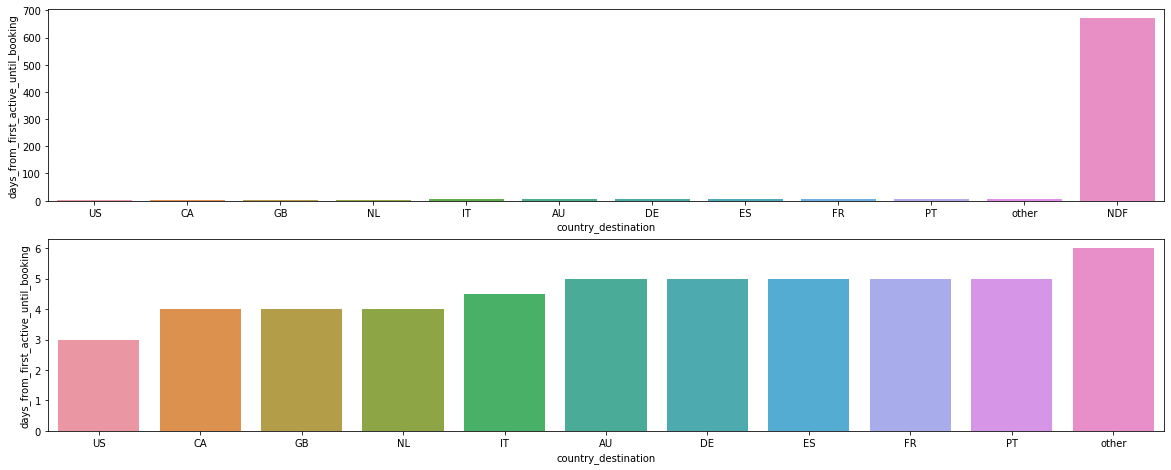

In [46]:

plt.figure( figsize=(20, 12))
plt.subplot( 3, 1, 1 )
aux01 = df51[['days_from_first_active_until_booking', 'country_destination']].groupby( 'country_destination' ).median().reset_index()
sns.barplot( x='country_destination', y='days_from_first_active_until_booking', 
             data=aux01.sort_values( 'days_from_first_active_until_booking' ) )

# remove outlier
plt.subplot( 3, 1, 2 )
aux02 = df51[df51['country_destination'] != 'NDF']
aux02 = aux02[['days_from_first_active_until_booking', 'country_destination']].groupby( 'country_destination' ).median().reset_index()
sns.barplot( x='country_destination', y='days_from_first_active_until_booking', 
             data=aux02.sort_values( 'days_from_first_active_until_booking' ) )

**H02**. Em todos os destinos, os usuários levam 3 dias em média, para fazer o cadastro no site

**Verdadeiro** Em todos os destinos os usuario levam até 2 dias para ativar o cadastro

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_account_created'>

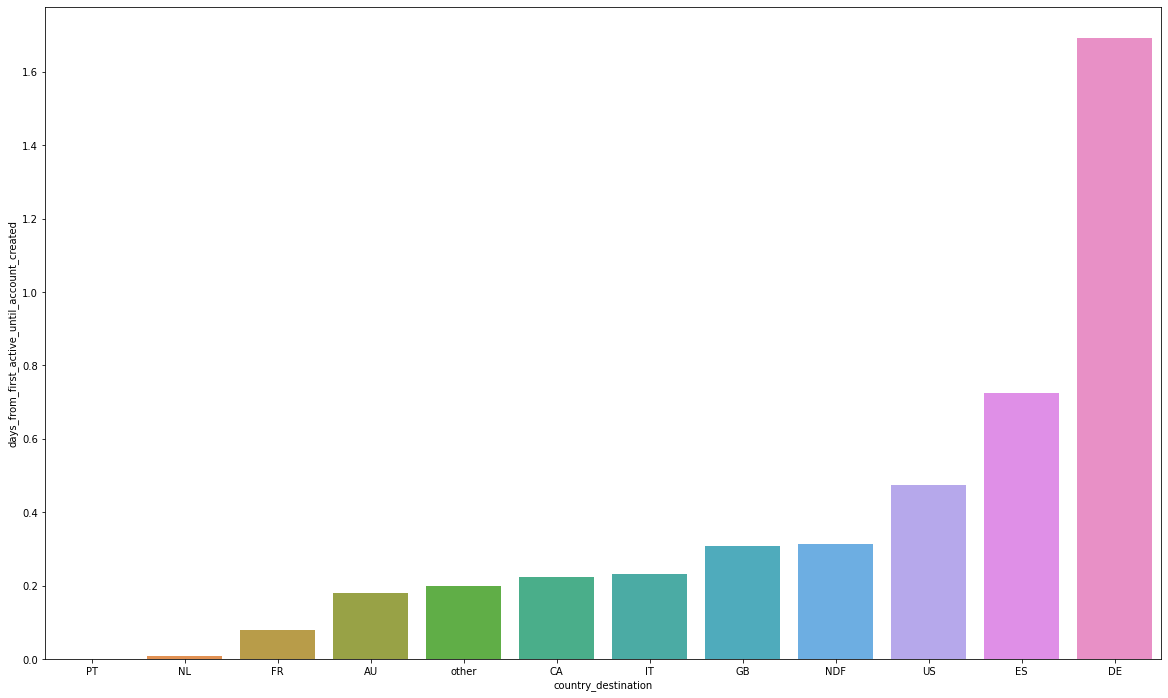

In [47]:

plt.figure( figsize=(20, 12))
aux01 = df51[['days_from_first_active_until_account_created', 'country_destination']].groupby( 'country_destination' ).mean().reset_index()
sns.barplot( x='country_destination', y='days_from_first_active_until_account_created', 
             data=aux01.sort_values( 'days_from_first_active_until_account_created' ) )

**H03**. O Volume de reserva anual feitas durante  o verão aumentaram 20% para destinos dentro dos USA

**Falsa** Há um volume maior que 20% até 2013, depois elas caem.

<AxesSubplot:xlabel='year_first_booking', ylabel='delta'>

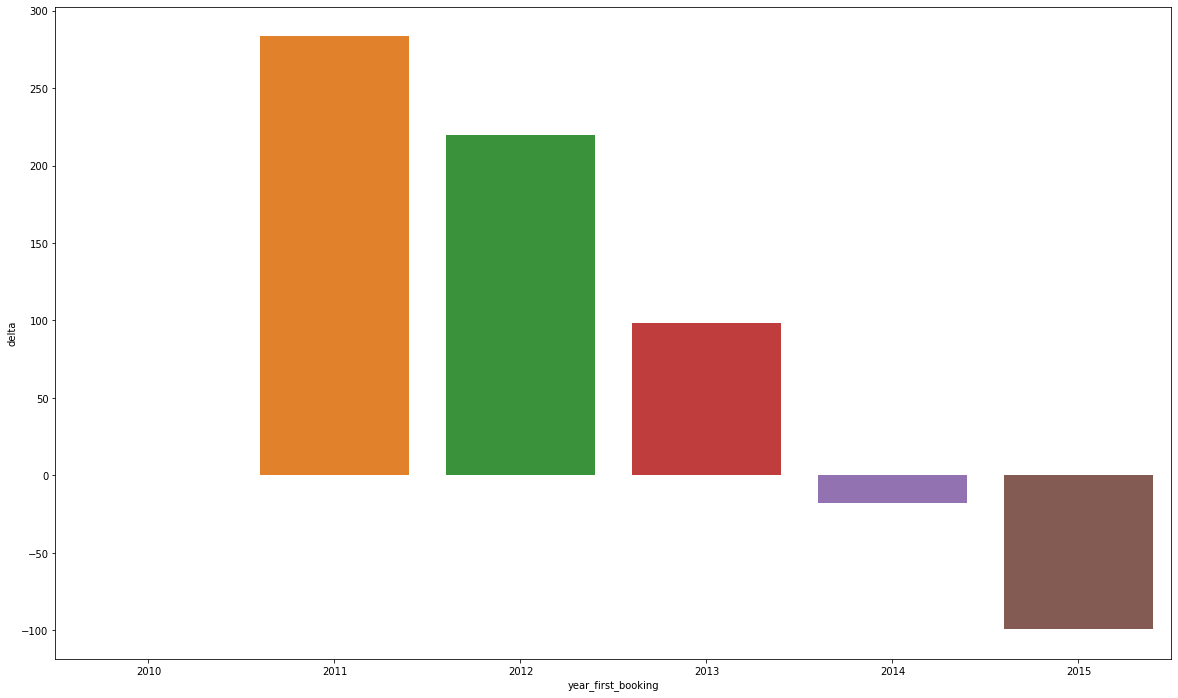

In [48]:
aux01 = df51[['year_first_booking', 'month_first_booking', 'country_destination']].\
                groupby( ['year_first_booking', 'month_first_booking', 'country_destination'] ). \
                size().reset_index().rename( columns={0:'count'})

# select only summer
aux01 = aux01[( aux01['month_first_booking'].isin( [6, 7, 8, 9] ) ) & (aux01['country_destination'] == 'US')]

aux02 = aux01[['year_first_booking', 'count']].groupby( 'year_first_booking' ).sum().reset_index()

aux02['delta'] = 100*aux02['count'].pct_change().fillna( 0 )

plt.figure( figsize=(20,12))
sns.barplot( x='year_first_booking', y='delta', data=aux02)

**H04**. Os usuários do sexo feminino fazem 10% mais reservas fara fora dos USA

In [82]:
aux = df51[df51['gender'].isin(['FEMALE','MALE'])]
aux

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,year_first_booking,month_first_booking,day_first_booking,day_of_week_first_booking,week_of_year_first_booking,year_account_created,month_account_created,day_account_created,day_of _week_first_account_created,week_of _year_first_account_created
1,820tgsjxq7,MALE,38,facebook,0,en,seo,google,untracked,Web,...,2015,6,29,0,27,2011,5,25,2,21
2,4ft3gnwmtx,FEMALE,56,basic,3,en,direct,direct,untracked,Web,...,2010,8,2,0,31,2010,9,28,1,39
3,bjjt8pjhuk,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,...,2012,9,8,5,36,2011,12,5,0,49
6,lsw9q7uk0j,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,...,2010,1,5,1,1,2010,1,2,5,53
7,0d01nltbrs,FEMALE,47,basic,0,en,direct,direct,omg,Web,...,2010,1,13,2,2,2010,1,3,6,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213440,04y8115avm,FEMALE,24,basic,25,en,direct,direct,untracked,iOS,...,2015,6,29,0,27,2014,6,30,0,27
213441,omlc9iku7t,FEMALE,34,basic,0,en,direct,direct,linked,Web,...,2014,8,13,2,33,2014,6,30,0,27
213443,0k26r3mir0,FEMALE,36,basic,0,en,sem-brand,google,linked,Web,...,2014,7,13,6,28,2014,6,30,0,27
213445,qbxza0xojf,FEMALE,23,basic,0,en,sem-brand,google,omg,Web,...,2014,7,2,2,27,2014,6,30,0,27


In [50]:
gender = pd.crosstab(index=df51["country_destination"]=='US', 
             columns=df51["gender"])

#gender_exited.index= ["Cliente","Deixou de ser cliente"]
gender
#sns.displot(x='gender', y='country_destination', data=gender)

gender,-unknown-,FEMALE,MALE,OTHER
country_destination,,,,
False,8003,35295,31158,123
True,8562,21067,18326,102


**H05**. O Canal de mkt do google representa 40% das reservas para fora dos USA

**H06**. Destino dentro dos USA, representa 20% em todos os canais

**H07**. A idade média das pessoas é de 35 anos em todos os destinos

**H08**. A porcentagem de usuarios que usam o site na lingua ingles_Americano para reservar acomodações em qualquer destino é maior que 40%

**H09**. O número de reservas do airbnb é crescente ou decrescente ao longo dos anos?

**H10**. O número de reservas do airbnb é crescente ao longo dos anos?

O objetivo de usar o pandas profiling:
 - ter uma visão geral das variáveis,
 - Encontrar as váriáveis que não carregam nenhuma informação,
 - Descobrir as variáveis muito correlacionadas, pois variáveis com grande correlação tem as mesmas informações.

## Impacto das Variáveis

In [51]:
#profile = ProfileReport(df52, title="Pandas Profiling Report")
#profile.to_file("airbnb_booking_statistics_after_cleaning.html")

In [52]:
df52 = df4.copy()

Nesta etapa usaremos os dados balanceados, pois o objetivo é aprender os dados em relação ao modelo ML

### Univariate Analysis

O Objetivo da Análise Univaridade é estudar as variáveis e verificar como elas impactam a variável resposta

O Obetivo da Análise Univariada:

    - Verificar a distribuição dos dados
    - Minimo, Máximo e Range
    - Observar os quartis (Q1 e Q3)
    - Skew e Kurtosis

### Bivariate Analysis

O Objetivo:
 - pode ser continua, ordinal ou categórica
 - Verificar o impacto de duas variáveis combinadas

### Multivariate Analysis

In [53]:
cols = ['days_from_first_active_until_booking',  'year_first_active',  'month_first_active', 'day_first_active',
        'day_of_week_first_active', 'week_of_year_first_active', 'month_first_booking', 'month_account_created',
        'year_first_booking', 'week_of_year_first_booking', 'affiliate_provider',
        'first_browser', 'first_device_type', 'language'] # high correlation

## 6.0 - DATA PREPARATION

In [54]:
df6 = df46.drop(cols, axis=1)

In [55]:
df6.dtypes

age                                               int64
signup_flow                                       int64
days_from_first_active_until_account_created      int64
days_from_account_created_until_first_booking     int64
day_first_booking                                 int64
day_of_week_first_booking                         int64
year_account_created                              int64
day_account_created                               int64
day_of _week_first_account_created                int64
week_of _year_first_account_created               int64
gender                                           object
signup_method                                    object
affiliate_channel                                object
first_affiliate_tracked                          object
signup_app                                       object
country_destination                              object
dtype: object

## 6.1 Rescaling

In [56]:
ss = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

In [57]:
 # age - Standardization
df6['age'] = ss.fit_transform( df6[['age']].values )

# signup_flow - Robust Scaler
df6['signup_flow'] = rs.fit_transform( df6[['signup_flow']].values )

# days_from_first_active_until_account_created - Robust Scaler
df6['days_from_first_active_until_account_created'] = rs.fit_transform( df6[['days_from_first_active_until_account_created']].values )

# days_from_account_created_until_first_booking - Robust Scaler
df6['days_from_account_created_until_first_booking'] = rs.fit_transform( df6[['days_from_account_created_until_first_booking']].values )

# year_account_created - MinMax Scaler
df6['year_account_created'] = mms.fit_transform( df6[['year_account_created']].values )

## 6.2 Encoding

In [58]:
 te = TargetEncoder()

In [59]:
# gender - One Hot Encoder
df6 = pd.get_dummies( df6, prefix=['gender'], columns=['gender'] )

# signup_method - One Hot Encoder
df6 = pd.get_dummies( df6, prefix=['signup_method'], columns=['signup_method'] )

# signup_app - One Hot Encoder
df6 = pd.get_dummies( df6, prefix=['signup_app'], columns=['signup_app'] )

# affiliate_channel - Target Encoder
c = {'NDF':0, 'US':1, 'other':2, 'CA':3, 'FR':4, 'IT':5, 'ES':6, 'GB':7, 'NL':8, 'DE':9, 'AU':10, 'PT':11}
df6['affiliate_channel'] = te.fit_transform( df6[['affiliate_channel']].values, df6['country_destination'].map( c ) )

# first_affiliate_tracked - Target Encoder
df6['first_affiliate_tracked'] = te.fit_transform( df6[['first_affiliate_tracked']].values, df6['country_destination'].map( c ) )

## 6.3 Transformation

In [60]:
# week_of_year_account_created
df6['week_of _year_first_account_created_sin'] = df6['week_of _year_first_account_created'].apply( lambda x: np.sin( x * (2*np.pi/52 ) ) )
df6['week_of _year_first_account_created_cos'] = df6['week_of _year_first_account_created'].apply( lambda x: np.cos( x * (2*np.pi/52 ) ) )

# day_of_week_first_booking
df6['day_of_week_first_booking_sin'] = df6['day_of_week_first_booking'].apply( lambda x: np.sin( x * (2*np.pi/7 ) ) )
df6['day_of_week_first_booking_cos'] = df6['day_of_week_first_booking'].apply( lambda x: np.cos( x * (2*np.pi/7 ) ) )

# day_account_created
df6['day_account_created_sin'] = df6['day_account_created'].apply( lambda x: np.sin( x * (2*np.pi/31 ) ) )
df6['day_account_created_cos'] = df6['day_account_created'].apply( lambda x: np.cos( x * (2*np.pi/31 ) ) )

# day_of_week_account_created
df6['day_of _week_first_account_created_sin'] = df6['day_of _week_first_account_created'].apply( lambda x: np.sin( x * (2*np.pi/7 ) ) )
df6['day_of _week_first_account_created_cos'] = df6['day_of _week_first_account_created'].apply( lambda x: np.cos( x * (2*np.pi/7 ) ) )

# 7.0 Feature Selection

In [61]:
df7 = df6.copy()

In [62]:
X = df7.drop( 'country_destination', axis=1 )
y = df7['country_destination'].copy()

In [63]:
#Split dataset
X_train, X_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.2, random_state=32 ) 

# 8.0 MACHINE LEARNING MODEL

In [64]:
x_train = X_train
x_test = X_test

## 8.1 Baseline Model 

In [65]:
#random.choices(populacao =, weght= , k=)
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().to_list()
k_num = y_test.shape[0]
country_destination_weghts = df1['country_destination'].value_counts(normalize=True).sort_index().to_list()

# Modelo aleatório
yhat_random = random.choices(population= country_destination_list, 
                             weights = country_destination_weghts,
                             k = k_num)


### 8.1.1 Baseline Model Performance

Accuracy: 0.09250581193139175
Balanced Accuracy: 0.08381625818892542
Balanced Accuracy: 0.0005375268893209606


              precision    recall  f1-score   support

          AU       0.07      0.00      0.01      7362
          CA       0.08      0.01      0.01      8422
          DE       0.07      0.01      0.01      7588
          ES       0.09      0.01      0.02     10108
          FR       0.09      0.03      0.05      8820
          GB       0.10      0.02      0.03     10446
          IT       0.07      0.02      0.03      8079
         NDF       0.10      0.44      0.16     10946
          NL       0.08      0.00      0.01      9599
          PT       0.05      0.00      0.00      9450
          US       0.09      0.40      0.14      9487
       other       0.08      0.06      0.07      8951

    accuracy                           0.09    109258
   macro avg       0.08      0.08      0.05    109258
weighted avg       0.08      0.09      0.05    109258



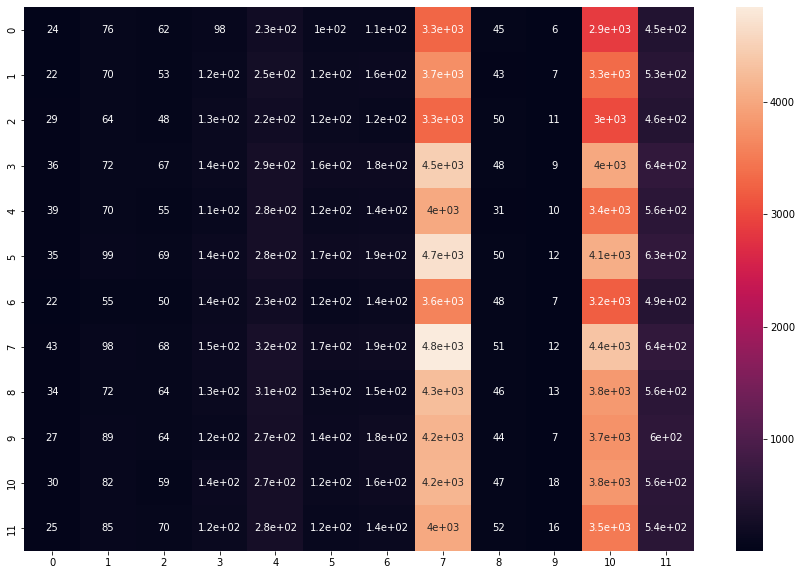

In [66]:
#Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print(f'Accuracy: {acc_random}')

#Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print(f'Balanced Accuracy: {balanced_acc_random}')

#Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print(f'Balanced Accuracy: {kappa_random}')
print('\n')

#Classification Report
print(m.classification_report(y_test, yhat_random))

#Confusion Matrix
cm = confusion_matrix( y_test, yhat_random)
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True);


## 8.2 Neural Network - MLP

In [67]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape(-1, 1 ) ).toarray()

In [68]:
print( 'Number of Rows: {}'.format( x_train.shape[0] ) )
print( 'Number of Features: {}'.format( x_train.shape[1] ) )
print( 'Number of Classes: {}'.format( y_train.nunique() ) )

Number of Rows: 437029
Number of Features: 31
Number of Classes: 12


In [69]:
# model definition
model = ml.Sequential()
model.add( l.Dense( 64, input_dim=x_train.shape[1], activation='relu' ) )
model.add( l.Dense( 12, activation='softmax') )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( x_train, y_train_nn, epochs=100 )

Epoch 1/100
13658/13658 [==============================] - 37s 2ms/step - loss: 2.1105 - accuracy: 0.2476
Epoch 2/100
13658/13658 [==============================] - 26s 2ms/step - loss: 2.0140 - accuracy: 0.2856
Epoch 3/100
13658/13658 [==============================] - 28s 2ms/step - loss: 1.9750 - accuracy: 0.3014
Epoch 4/100
13658/13658 [==============================] - 28s 2ms/step - loss: 1.9528 - accuracy: 0.3093
Epoch 5/100
13658/13658 [==============================] - 29s 2ms/step - loss: 1.9388 - accuracy: 0.3137
Epoch 6/100
13658/13658 [==============================] - 29s 2ms/step - loss: 1.9281 - accuracy: 0.3177
Epoch 7/100
13658/13658 [==============================] - 27s 2ms/step - loss: 1.9202 - accuracy: 0.3210
Epoch 8/100
13658/13658 [==============================] - 27s 2ms/step - loss: 1.9126 - accuracy: 0.3241
Epoch 9/100
13658/13658 [==============================] - 26s 2ms/step - loss: 1.9061 - accuracy: 0.3262
Epoch 10/100
13658/13658 [====================

13658/13658 [==============================] - 23s 2ms/step - loss: 1.8553 - accuracy: 0.3422
Epoch 78/100
13658/13658 [==============================] - 24s 2ms/step - loss: 1.8548 - accuracy: 0.3413
Epoch 79/100
13658/13658 [==============================] - 24s 2ms/step - loss: 1.8542 - accuracy: 0.3422
Epoch 80/100
13658/13658 [==============================] - 24s 2ms/step - loss: 1.8547 - accuracy: 0.3421
Epoch 81/100
13658/13658 [==============================] - 24s 2ms/step - loss: 1.8543 - accuracy: 0.3420
Epoch 82/100
13658/13658 [==============================] - 25s 2ms/step - loss: 1.8538 - accuracy: 0.3415
Epoch 83/100
13658/13658 [==============================] - 24s 2ms/step - loss: 1.8548 - accuracy: 0.3424
Epoch 84/100
13658/13658 [==============================] - 23s 2ms/step - loss: 1.8534 - accuracy: 0.3422
Epoch 85/100
13658/13658 [==============================] - 21s 2ms/step - loss: 1.8535 - accuracy: 0.3425
Epoch 86/100
13658/13658 [========================

## 8.2.2 NN Performance

In [70]:
#Predict
pred_nn = model.predict( x_test )

#invert prediction
yhat_nn = ohe.inverse_transform( pred_nn)

#Prediction Prepare
y_test_nn = y_test.to_numpy()
yhat_nn =  yhat_nn.reshape(1, -1 )[0]

3415/3415 [==============================] - 5s 1ms/step


Accuracy: 0.34194292408793864
Balanced Accuracy: 0.32474099772691795
Kappa score: 0.2802705212900243


              precision    recall  f1-score   support

          AU       0.29      0.34      0.31      7362
          CA       0.19      0.13      0.16      8422
          DE       0.21      0.15      0.18      7588
          ES       0.18      0.24      0.21     10108
          FR       0.14      0.12      0.13      8820
          GB       0.18      0.13      0.15     10446
          IT       0.16      0.08      0.11      8079
         NDF       1.00      1.00      1.00     10946
          NL       0.26      0.44      0.33      9599
          PT       0.60      0.89      0.71      9450
          US       0.25      0.33      0.28      9487
       other       0.17      0.04      0.06      8951

    accuracy                           0.34    109258
   macro avg       0.30      0.32      0.30    109258
weighted avg       0.31      0.34      0.32    109258



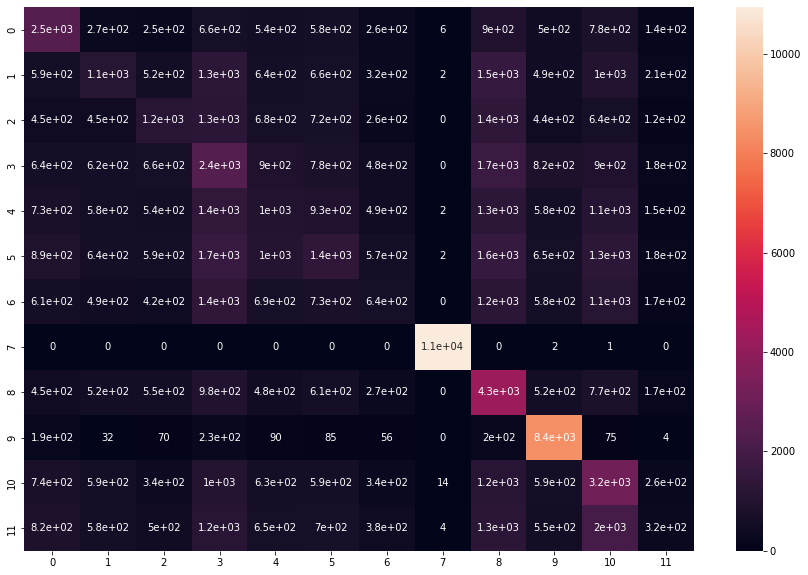

In [71]:
#Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print(f'Accuracy: {acc_nn}')

#Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

#Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print(f'Kappa score: {kappa_nn}')
print('\n')

#Classification Report
print(m.classification_report(y_test_nn, yhat_nn))

#Confusion Matrix
cm = confusion_matrix( y_test_nn, yhat_nn)
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True);



## 8.2.3 NN Performance - Cross Validation

In [ ]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( x_train, y_train ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
    model.add( l.Dense( 12, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

In [72]:
#Generate k-fold
#num_folds = 5
#kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)
#
#balanced_acc_list = []
#kappa_acc_list = []
#
#i = 1
#
#for train_ix, val_ix in kfold.split(x_train, y_train):
#    print(f'Fold number {i}/{num_folds}\n')
#    #Get fold
#    x_train_fold = x_train.iloc[train_ix]
#    y_train_fold = y_train.iloc[train_ix]
#   
#    x_val_fold = x_train.iloc[val_ix]
#    y_val_fold = y_train.iloc[val_ix]
#    
#    #target hot_encoding
#    ohe = pp.OneHotEncoder()
#    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape( -1, 1)).toarray()
#    
#    #Model definition
#    model = ml.Sequential()
#    model.add(l.Dense(256, input_dim=x_train.shape[1], activation='relu'))
#    model.add(l.Dense(12, activation='softmax'))
#    
#    #Compile Model
#    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#    
#    #training model
#    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)
#    
#    
#    # prediction
#    pred_nn = model.predict(x_val_fold)
#    yhat_nn = ohe.inverse_transform( pred_nn)
#    
#    #prepare data
#    y_test_nn = y_val_fold.to_numpy()
#    yhat_nn = yhat_nn.reshape( 1, -1)[0]
#    
#    #metrics
#    
#    #Balanced Accuracy
#    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
#    balanced_acc_list.append( balanced_acc_nn)
#   
#    #Kappa Metrics
#    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
#    kappa_acc_list.append( kappa_acc_nn)
#    
#    i += 1

Fold number 1/5

2732/2732 [==============================] - 3s 1ms/step
Fold number 2/5

2732/2732 [==============================] - 4s 1ms/step
Fold number 3/5

2732/2732 [==============================] - 3s 1ms/step
Fold number 4/5

2732/2732 [==============================] - 3s 1ms/step
Fold number 5/5

2732/2732 [==============================] - 3s 1ms/step


In [73]:
print(f'Avg Balanced Accuracy: {np.mean(balanced_acc_list)} +/- {np.std(balanced_acc_list)}\n')
      
print(f'Avg Kappa: {np.mean(kappa_acc_list)} +/- {np.std(kappa_acc_list)}')

Avg Balanced Accuracy: 0.44066432992312105 +/- 0.0018747300350178933

Avg Kappa: 0.39978722155779817 +/- 0.002618184922024093
